In [1]:
import pandas as pd
import numpy as np
import json
from pandas import json_normalize
# from google.colab import files
import pyarrow.parquet as pq
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re
import string
import gensim

import matplotlib as mpl
import matplotlib.pyplot as plt

from pythainlp.corpus import (thai_stopwords, 
                              thai_words,
                              thai_syllables,
                              thai_family_names,
                              thai_female_names,
                              thai_male_names)
from pythainlp.corpus.ttc import word_freqs
from pythainlp.tokenize import word_tokenize
from pythainlp.util import normalize
from collections import Counter
from gensim import corpora
from gensim.models import TfidfModel, LsiModel
from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# Set plot option
# Retina display
%config InlineBackend.figure_format = 'retina'

# Thai font
mpl.font_manager.fontManager.addfont('THSarabunNew.ttf')
mpl.rc('font', family = 'TH Sarabun New', size = 20)

In [3]:
# df = pd.read_parquet('review.parquet')
# df = pd.DataFrame(df.review_body)
# df = df.loc[0:999]

df = pd.read_csv('data.csv')
df

,review_body
0,มาแล้ว ร้านโปรดในดวงใจ ร้านนี้เวลาจะมากินเตรีย...
1,ร้านโมโม่พาราไดซ์เป็นร้านบุฟเฟ่ชาบูร้านดังที่ม...
2,แกคือร้านชาบูในดวงใจของฉัน คิดอะไรไม่ออกพรุ่งต...
3,ร้านชาบูชื่อดัง ใครๆก็ต้องรู้จัก “MoMo Paradis...
4,หลังจากตกลงกันว่าจะทานอะไร สุดท้ายจบที่โมโม มี...
5,แนะนำชาบู-สุกี้ต้นตำรับจากญี่ปุ่น สำหรับสายเนื...
6,ปกติทานโมโม่ก็ทานที่ร้านตลอดเลยค่ะ มีเปลี่ยนสา...
7,วันนี้ผ่านมาอโศก เป็นครั้งแรกที่ได้มาลองสาขานี...
8,มาทานโมโม่มื้อเย็นวันอาทิตย์ แทบไม่ต้องรอคิวเล...
9,ไม่ได้ทานโมโม่นานมาก กลับมาทานอีกทีก็เลยอาจจะพ...


In [4]:
# Clean tweet text
# Define emoji Unicode first
emoji = re.compile("["
                   u"\U0001F600-\U0001F64F"  #Emoticons
                   u"\U0001F300-\U0001F5FF"  #Symbols & pictographs
                   u"\U0001F680-\U0001F6FF"  #Transport & map symbols
                   u"\U0001F1E0-\U0001F1FF"  #Flags (iOS)
                   u"\U00002500-\U00002BEF"  #Chinese char
                   u"\U00002702-\U000027B0"
                   u"\U00002702-\U000027B0"
                   u"\U000024C2-\U0001F251"
                   u"\U0001f926-\U0001f937"
                   u"\U00010000-\U0010ffff"
                   u"\u2640-\u2642"
                   u"\u2600-\u2B55"
                   u"\u200d"
                   u"\u23cf"
                   u"\u23e9"
                   u"\u231a"
                   u"\ufe0f"  #Dingbats
                   u"\u3030"
                   "]+", flags = re.UNICODE) #Flag option as Unicode

# Remove (.) out from punctuation string
newPunc = ''.join(set(string.punctuation) - {'.'})

# Define function for text cleansing
def cleanText(text):
  newText = re.sub(r'(?:http|ftp|https)://(?:[\w_-]+(?:(?:\.[\w_-]+)+))(?:[\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '', text) #Remove link
  newText = re.sub(emoji, '', newText) #Remove emoji
  # newText = re.sub(r'@([a-zA-Z0-9_]{1,50})', '', newText) #Remove @username
  # newText = re.sub(r'#([a-zA-Z0-9ก-๙_]+)', '', newText) #Remove hashtag
  # # newText = re.sub(r'RT', '', newText) #Remove 'RT' Word from tweet
  # remove words
  rm_word = ['',' ','    ','\n', '(', ')', '?', '+', '--', '//', 'ร้าน', '\u200b', 'ๆ(', '..', 'ๆๆๆๆ', 'ๆ', 'นะคะ', '-', '!', 'โมโม่', 'momo']
  for i in rm_word:
    newText = newText.replace(i, '')
  newText = newText.translate(str.maketrans('', '', newPunc)) #Remove punctuation without (.)
  newText = ' '.join(newText.split()) #Keep only one white space
  return newText

In [5]:
print('original text:\n',df.review_body[2])
print('clean text:\n',cleanText(df.review_body[2]))

original text:
 แกคือร้านชาบูในดวงใจของฉัน คิดอะไรไม่ออกพรุ่งตัวมาโมโม่จ้า
ชอบมากเนื้อร้านเค้าเนี่ยแล้วยิ่งไอไก่ไม้ไผ่นะ คือมันจะอร่อยเกินไปป่ะเอาจริงๆที่ชอบที่สุดเลยก็คือน้ำซุป คือมันเป็นเอกลักษณ์ประจำร้านมากแล้วไหนจะน้ำจิ้มงาของโมโม่อีกคือมันอร่อยไปหมดเลยอ่ะ
แล้วแกดูไอติมของหวานที่ฉันกินไปคือมันเยอะมากบอกเลยว่ามาร้านเดียวจบครบทั้งของคาวของหวาน
clean text:
 แกคือชาบูในดวงใจของฉันคิดอะไรไม่ออกพรุ่งตัวมาจ้าชอบมากเนื้อเค้าเนี่ยแล้วยิ่งไอไก่ไม้ไผ่นะคือมันจะอร่อยเกินไปป่ะเอาจริงที่ชอบที่สุดเลยก็คือน้ำซุปคือมันเป็นเอกลักษณ์ประจำมากแล้วไหนจะน้ำจิ้มงาของอีกคือมันอร่อยไปหมดเลยอ่ะแล้วแกดูไอติมของหวานที่ฉันกินไปคือมันเยอะมากบอกเลยว่ามาเดียวจบครบทั้งของคาวของหวาน


In [6]:
df['clean_text'] = df.review_body.apply(cleanText)
df

,review_body,clean_text
0,มาแล้ว ร้านโปรดในดวงใจ ร้านนี้เวลาจะมากินเตรีย...,มาแล้วโปรดในดวงใจนี้เวลาจะมากินเตรียมตัวเด้ออด...
1,ร้านโมโม่พาราไดซ์เป็นร้านบุฟเฟ่ชาบูร้านดังที่ม...,พาราไดซ์เป็นบุฟเฟ่ชาบูดังที่มักจะตั้งอยู่ตามห้...
2,แกคือร้านชาบูในดวงใจของฉัน คิดอะไรไม่ออกพรุ่งต...,แกคือชาบูในดวงใจของฉันคิดอะไรไม่ออกพรุ่งตัวมาจ...
3,ร้านชาบูชื่อดัง ใครๆก็ต้องรู้จัก “MoMo Paradis...,ชาบูชื่อดังใครก็ต้องรู้จัก“MoMoParadise”สาขาเท...
4,หลังจากตกลงกันว่าจะทานอะไร สุดท้ายจบที่โมโม มี...,หลังจากตกลงกันว่าจะทานอะไรสุดท้ายจบที่โมโมมีคิ...
5,แนะนำชาบู-สุกี้ต้นตำรับจากญี่ปุ่น สำหรับสายเนื...,แนะนำชาบูสุกี้ต้นตำรับจากญี่ปุ่นสำหรับสายเนื้อ...
6,ปกติทานโมโม่ก็ทานที่ร้านตลอดเลยค่ะ มีเปลี่ยนสา...,ปกติทานก็ทานที่ตลอดเลยค่ะมีเปลี่ยนสาขาบ้างอะไร...
7,วันนี้ผ่านมาอโศก เป็นครั้งแรกที่ได้มาลองสาขานี...,วันนี้ผ่านมาอโศกเป็นครั้งแรกที่ได้มาลองสาขานี้...
8,มาทานโมโม่มื้อเย็นวันอาทิตย์ แทบไม่ต้องรอคิวเล...,มาทานมื้อเย็นวันอาทิตย์แทบไม่ต้องรอคิวเลยครับค...
9,ไม่ได้ทานโมโม่นานมาก กลับมาทานอีกทีก็เลยอาจจะพ...,ไม่ได้ทานนานมากกลับมาทานอีกทีก็เลยอาจจะพลาดไม่...


In [7]:
# Word preparation
# Keep words
thaiwords = thai_words()
syllables = thai_syllables()
familyname = thai_family_names()
femalename = thai_female_names()
malename = thai_male_names()

# Remove words
# Thai stop words
stopwords = thai_stopwords()

# Thai frequency word
freqswords = word_freqs()
freq = 100 #Set frequency
freqsResults = []

for line in list(freqswords):
  if line[1] >= freq: #More than threshold means frequency
    freqsResults.append(line[0])

In [8]:
# Tokenize 
words = []

for i, text in enumerate(df['clean_text']):
  tokenText = word_tokenize(text, engine = 'nercut', keep_whitespace = False) #Using 'nercut'
  tokenText = [normalize(word) for word in tokenText] #Normalization word
  tokenText = [word for word in tokenText if not word in stopwords] #Remove Thai stop words
  tokenText = [word for word in tokenText if not word in freqsResults] #Remove Thai frequency words
  tokenText = [word for word in tokenText if word in thaiwords or word in familyname or word in femalename or word in malename or word in syllables] #Keep Thai word and name
  words.append(tokenText)

  # Print process
  if i % 10000 == 0:
    print(f'Word processing: {i}')

# Remove empty list
cleanWords = [input for input in words if input]

# Count frequency in list of list
frequency = Counter(word for token in cleanWords for word in set(token)) 

# Remove words that appear only once
cleanWords = [
              [token for token in word if frequency[token] > 1]
              for word in cleanWords
]

Word processing: 0


In [9]:
# Sample
print(f'Sample word tokenized:\n{cleanWords[:1]}')

Sample word tokenized:
[['ดวงใจ', 'คิว', 'คิว', 'กินที่', 'ที่นี่', 'สไลด์', 'สไลด์', 'สไลด์', 'น้ำจิ้ม']]


In [10]:
# Topic model
# Create dictionary from text
dictionary = corpora.Dictionary(cleanWords) #Unique term
corpus = [dictionary.doc2bow(word) for word in cleanWords] #Create index of word from dictionary

# Sample
print(f'Sample word index:\n{corpus[:3]}')

Sample word index:
[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 3)], [(3, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1)], [(2, 1), (4, 1), (6, 1), (8, 1), (18, 2), (19, 1), (20, 1)]]


In [11]:
# Create TF-IDF Model from corpus
TFIDFModel = TfidfModel(corpus) #TF-IDF Model object
TFIDFCorpus = TFIDFModel[corpus]

# Sample
for i in range(3):
  print(f'Sample TF-IDF token {i}:\n{TFIDFModel[corpus][i]}')

Sample TF-IDF token 0:
[(0, 0.28912939601370297), (1, 0.2005329128744904), (2, 0.28912939601370297), (3, 0.15117961581130682), (4, 0.1318233309603512), (5, 0.867388188041109)]
Sample TF-IDF token 1:
[(3, 0.18939409314111408), (6, 0.16071352345964215), (7, 0.25317684319542544), (8, 0.09404431412195075), (9, 0.29843142455240707), (10, 0.3622141746067185), (11, 0.37878818628222816), (12, 0.29843142455240707), (13, 0.25317684319542544), (14, 0.25317684319542544), (15, 0.29843142455240707), (16, 0.3622141746067185), (17, 0.25317684319542544)]
Sample TF-IDF token 2:
[(2, 0.5331173342691234), (4, 0.24306522880408926), (6, 0.11827141400641014), (8, 0.1384171508536334), (18, 0.4861304576081785), (19, 0.5331173342691234), (20, 0.3209686176468549)]


In [19]:
# LSA Model
nTopics = 2 #Set number of topics

# Build model
LSIModel = LsiModel(TFIDFCorpus,
                    id2word = dictionary,
                    num_topics = nTopics,
                    decay = 0.5,
                    extra_samples = 500)

# Print topics
LSIModel.print_topics()

[(0,
  '-0.258*"ซุป" + -0.256*"พนักงาน" + -0.202*"คิว" + -0.196*"คุ้ม" + -0.195*"ชาบู" + -0.191*"รสชาติ" + -0.189*"น้ำจิ้ม" + -0.186*"ของหวาน" + -0.170*"นุ่ม" + -0.170*"ไอติม"'),
 (1,
  '-0.542*"พนักงาน" + 0.227*"ของหวาน" + -0.209*"ถุงมือ" + 0.206*"ไอติม" + -0.199*"จอง" + 0.193*"สไลด์" + -0.174*"ฟิน" + -0.165*"โม" + 0.164*"เกินไป" + -0.156*"บาร์"')]

In [20]:
# Create summary tabel in DataFrame format
nWords = 15 #Set number of word in a topic
topicWords = None

for i, topic in enumerate(LSIModel.get_topics()):
  wordIndex = topic.argsort() #.argsort is sorting values by ascending (0 -> 1) and return index
  wordIndex = wordIndex[::-1][:nWords] #Get n index by descending order values from array
  value = topic[wordIndex] #Get values by array index
  word = [dictionary[id] for id in wordIndex] #Get word from dictionay[i], i represents index of word
  
  result = pd.DataFrame({'Topic': i + 1, 'Word': word, 'Value': value})
  if topicWords is None:
    topicWords = result.copy()
  else:
    topicWords = pd.concat([topicWords, result], axis = 0, ignore_index = True)

# Show result with pivot table
topicWords.groupby(['Topic'])['Word'].apply(lambda x: x.reset_index(drop = True)).unstack()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Topic,,,,,,,,,,,,,,,
1,กินที่,อุด้ง,เหมาะสำหรับ,ดิบ,อีกที,ได้ดี,คัสตาร์ด,กำลังดี,เมนู,อโศก,เครื่องดื่ม,ถาด,คุ้มค่า,คีบ,อันดับ
2,ของหวาน,ไอติม,สไลด์,เกินไป,พนักงานบริการ,ดวงใจ,เนื้อวัว,เนื้อหมู,ไดฟูกุ,ซุป,ที่นี่,โคล,บ๊วย,น้ำดื่ม,โมจิ


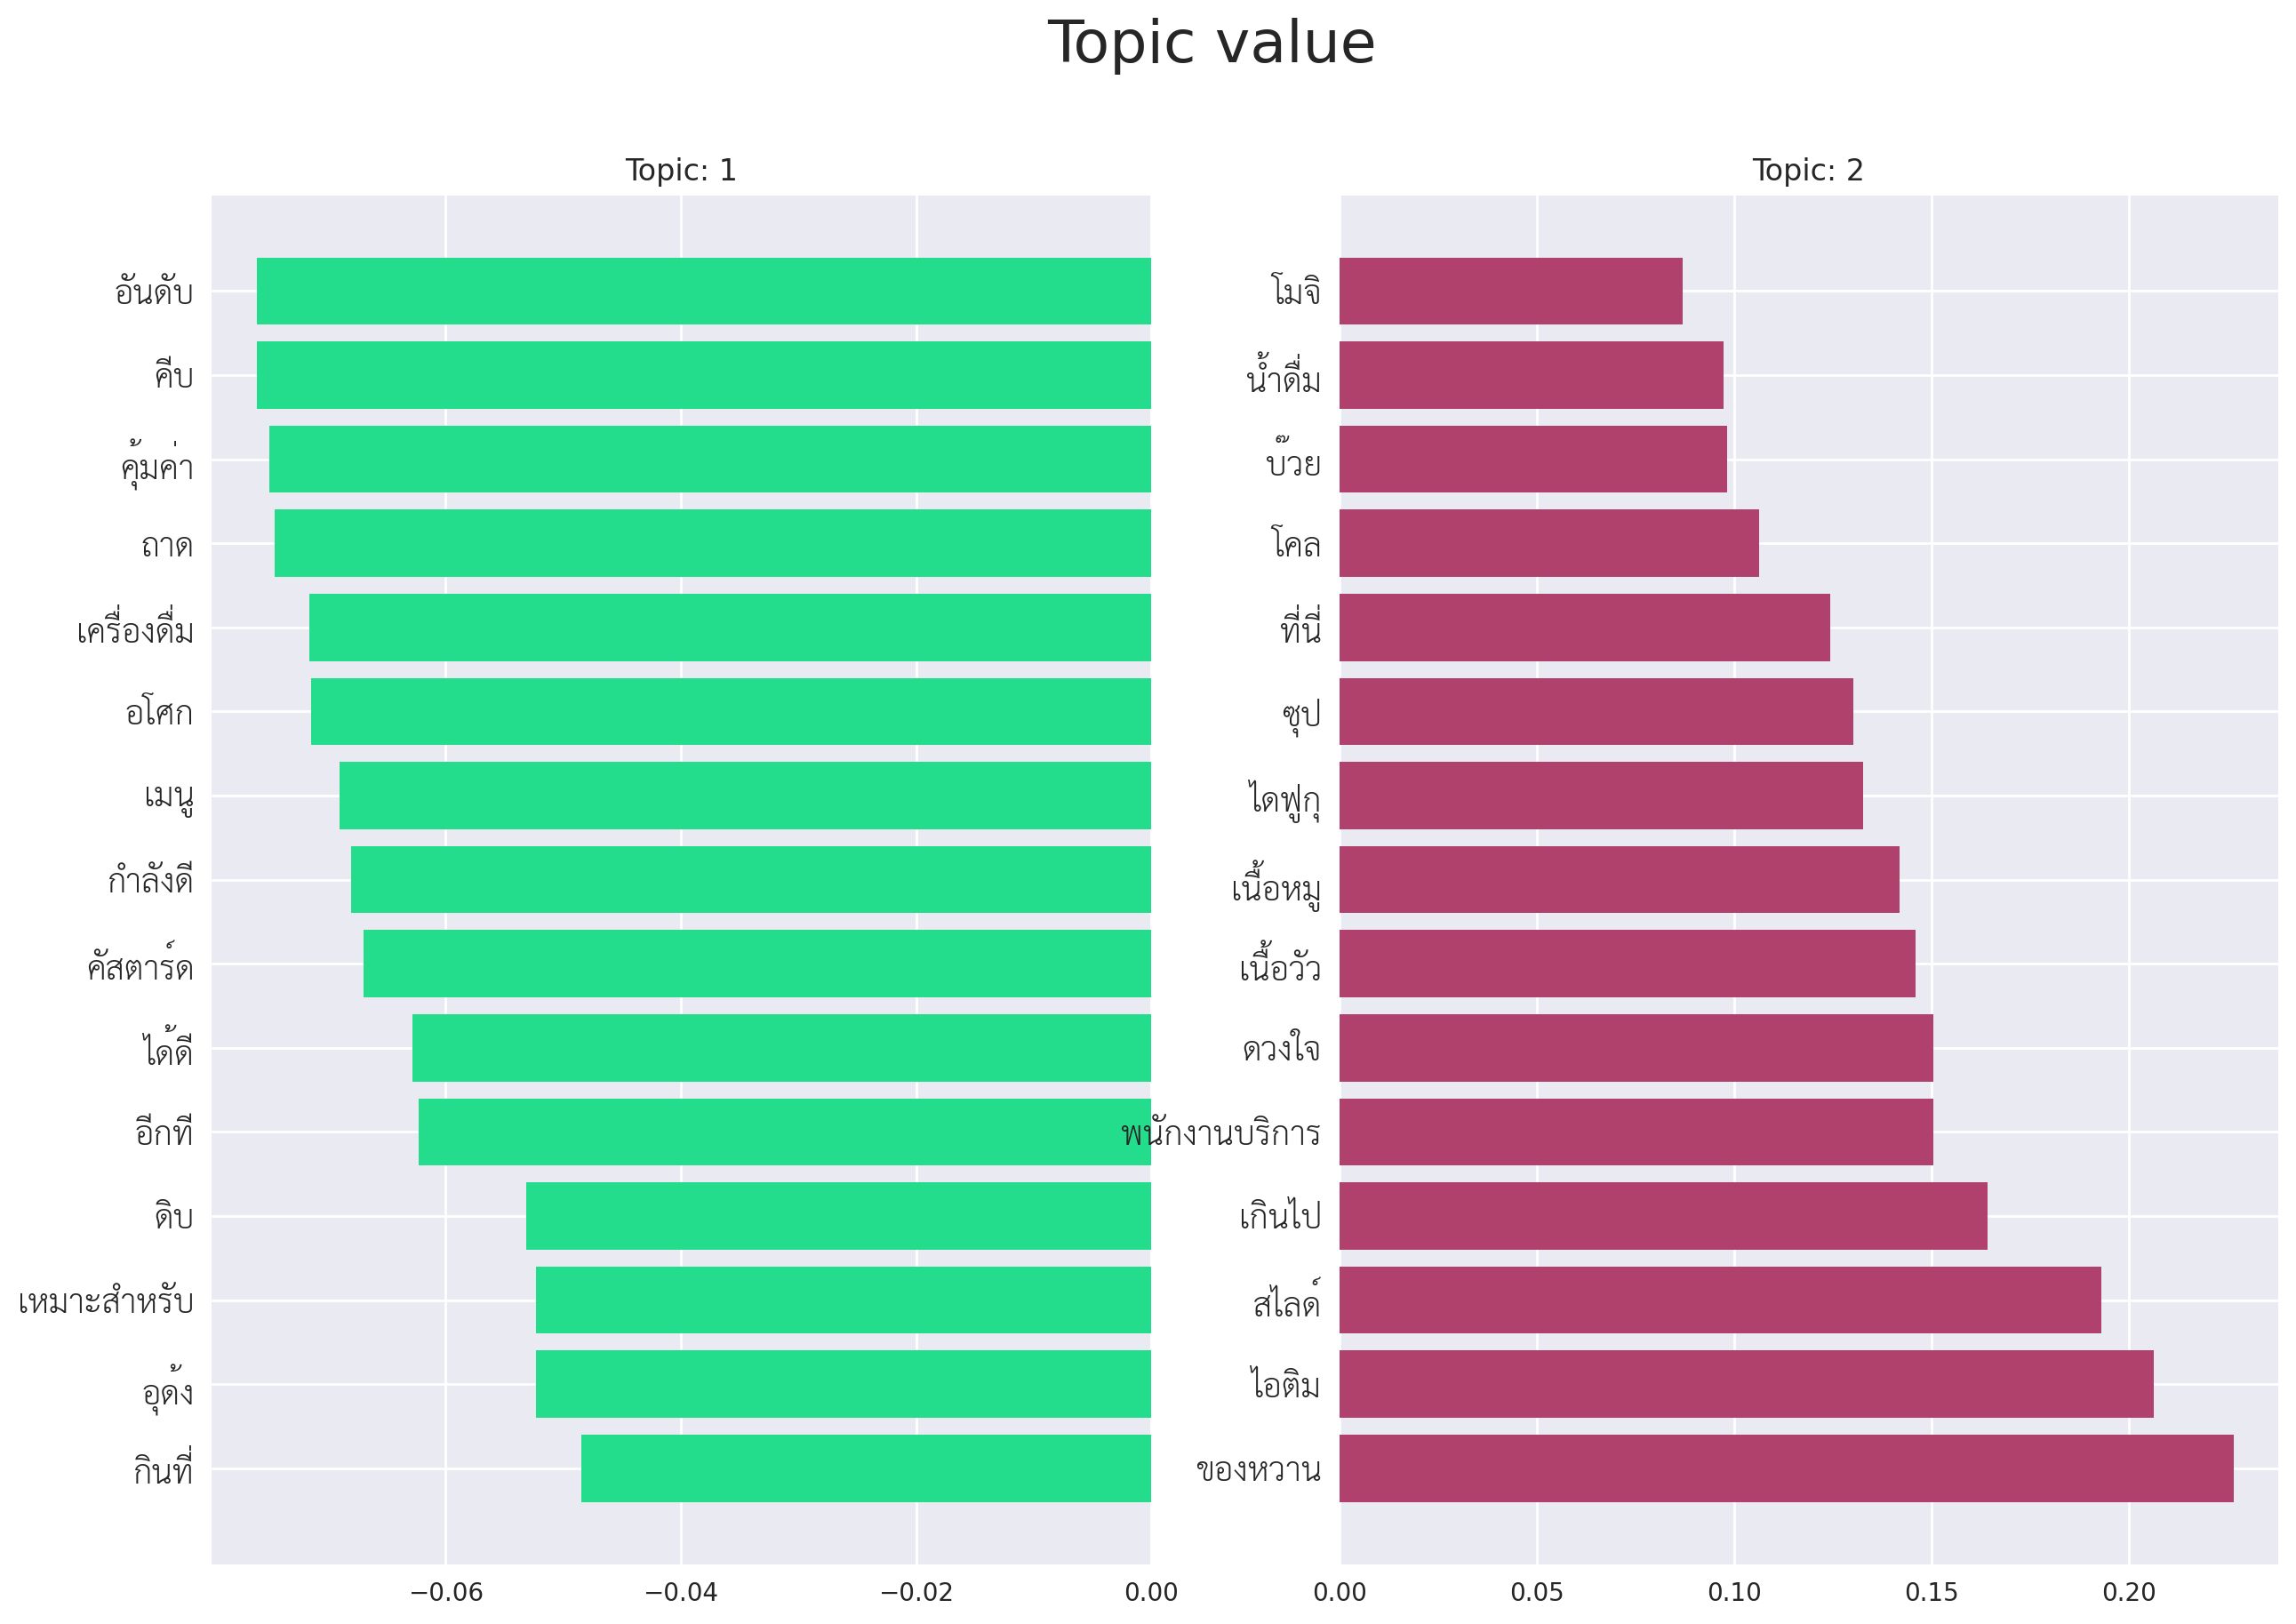

In [21]:
# Plot values
# Define font family
axsTickFont = {'family': 'TH Sarabun New',
               'size': 20}

with plt.style.context('seaborn'):
  fig, axs = plt.subplots(int(nTopics / 2), 2, figsize = (15, 10))
  fig.suptitle('Topic value')
  axs = axs.ravel()

  for i in range(nTopics):
    data = topicWords.query('Topic == @i + 1')
    value = data['Value']
    word = data['Word']
    position = np.arange(data.shape[0])
    axs[i].set_title(f'Topic: {i + 1}')
    axs[i].barh(position, value, color = np.random.rand(3))
    axs[i].set_yticks(position) #To set ticks based on number of labels
    axs[i].set_yticklabels(list(word), **axsTickFont) #**kwargs for Thai font option
# plt.savefig('wordValues.png')
plt.show()

In [22]:
# Define function word cloud
def plotWord(data):
  wordcloud = WordCloud(font_path = 'THSarabunNew.ttf',
                        width = 1200,
                        height = 800,
                        background_color = 'white',
                        regexp = r'[ก-๙]+').generate_from_text(' '.join(data))
  return wordcloud

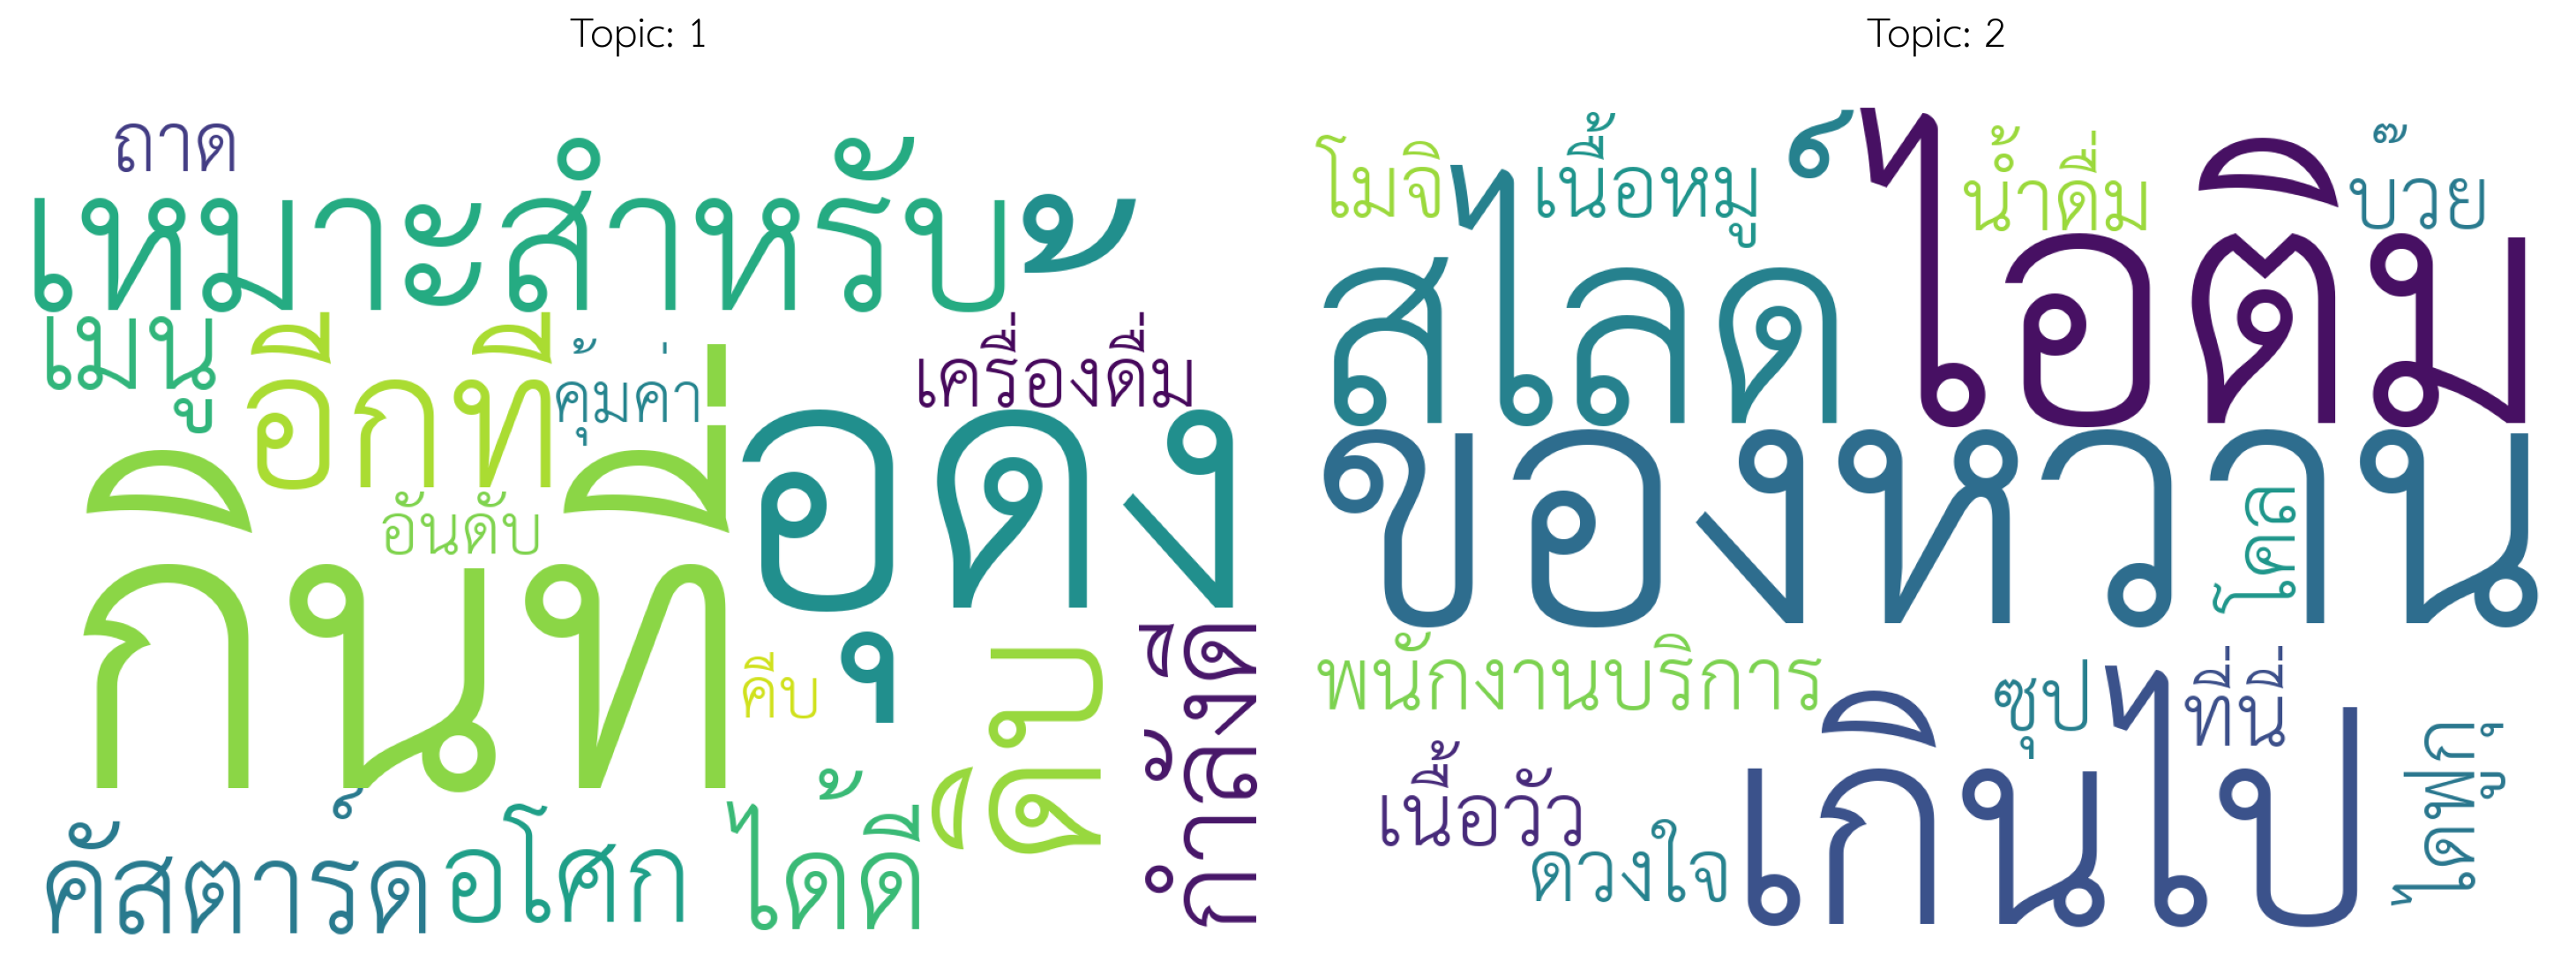

In [23]:
# Plot word cloud
fig = plt.figure(figsize = (15, 10))

for i in range(nTopics):
  data = topicWords.query('Topic == @i + 1')['Word'] #Extract only word
  ax = fig.add_subplot(int(nTopics / 2), 2, i + 1)
  ax.set_title(f'Topic: {i + 1}\n')
  wordcloud = plotWord(data)
  ax.imshow(wordcloud)
  ax.axis('off')
fig.tight_layout()
plt.show()
# fig.savefig('wordPlot.png')

# Topic Modeling with LDA

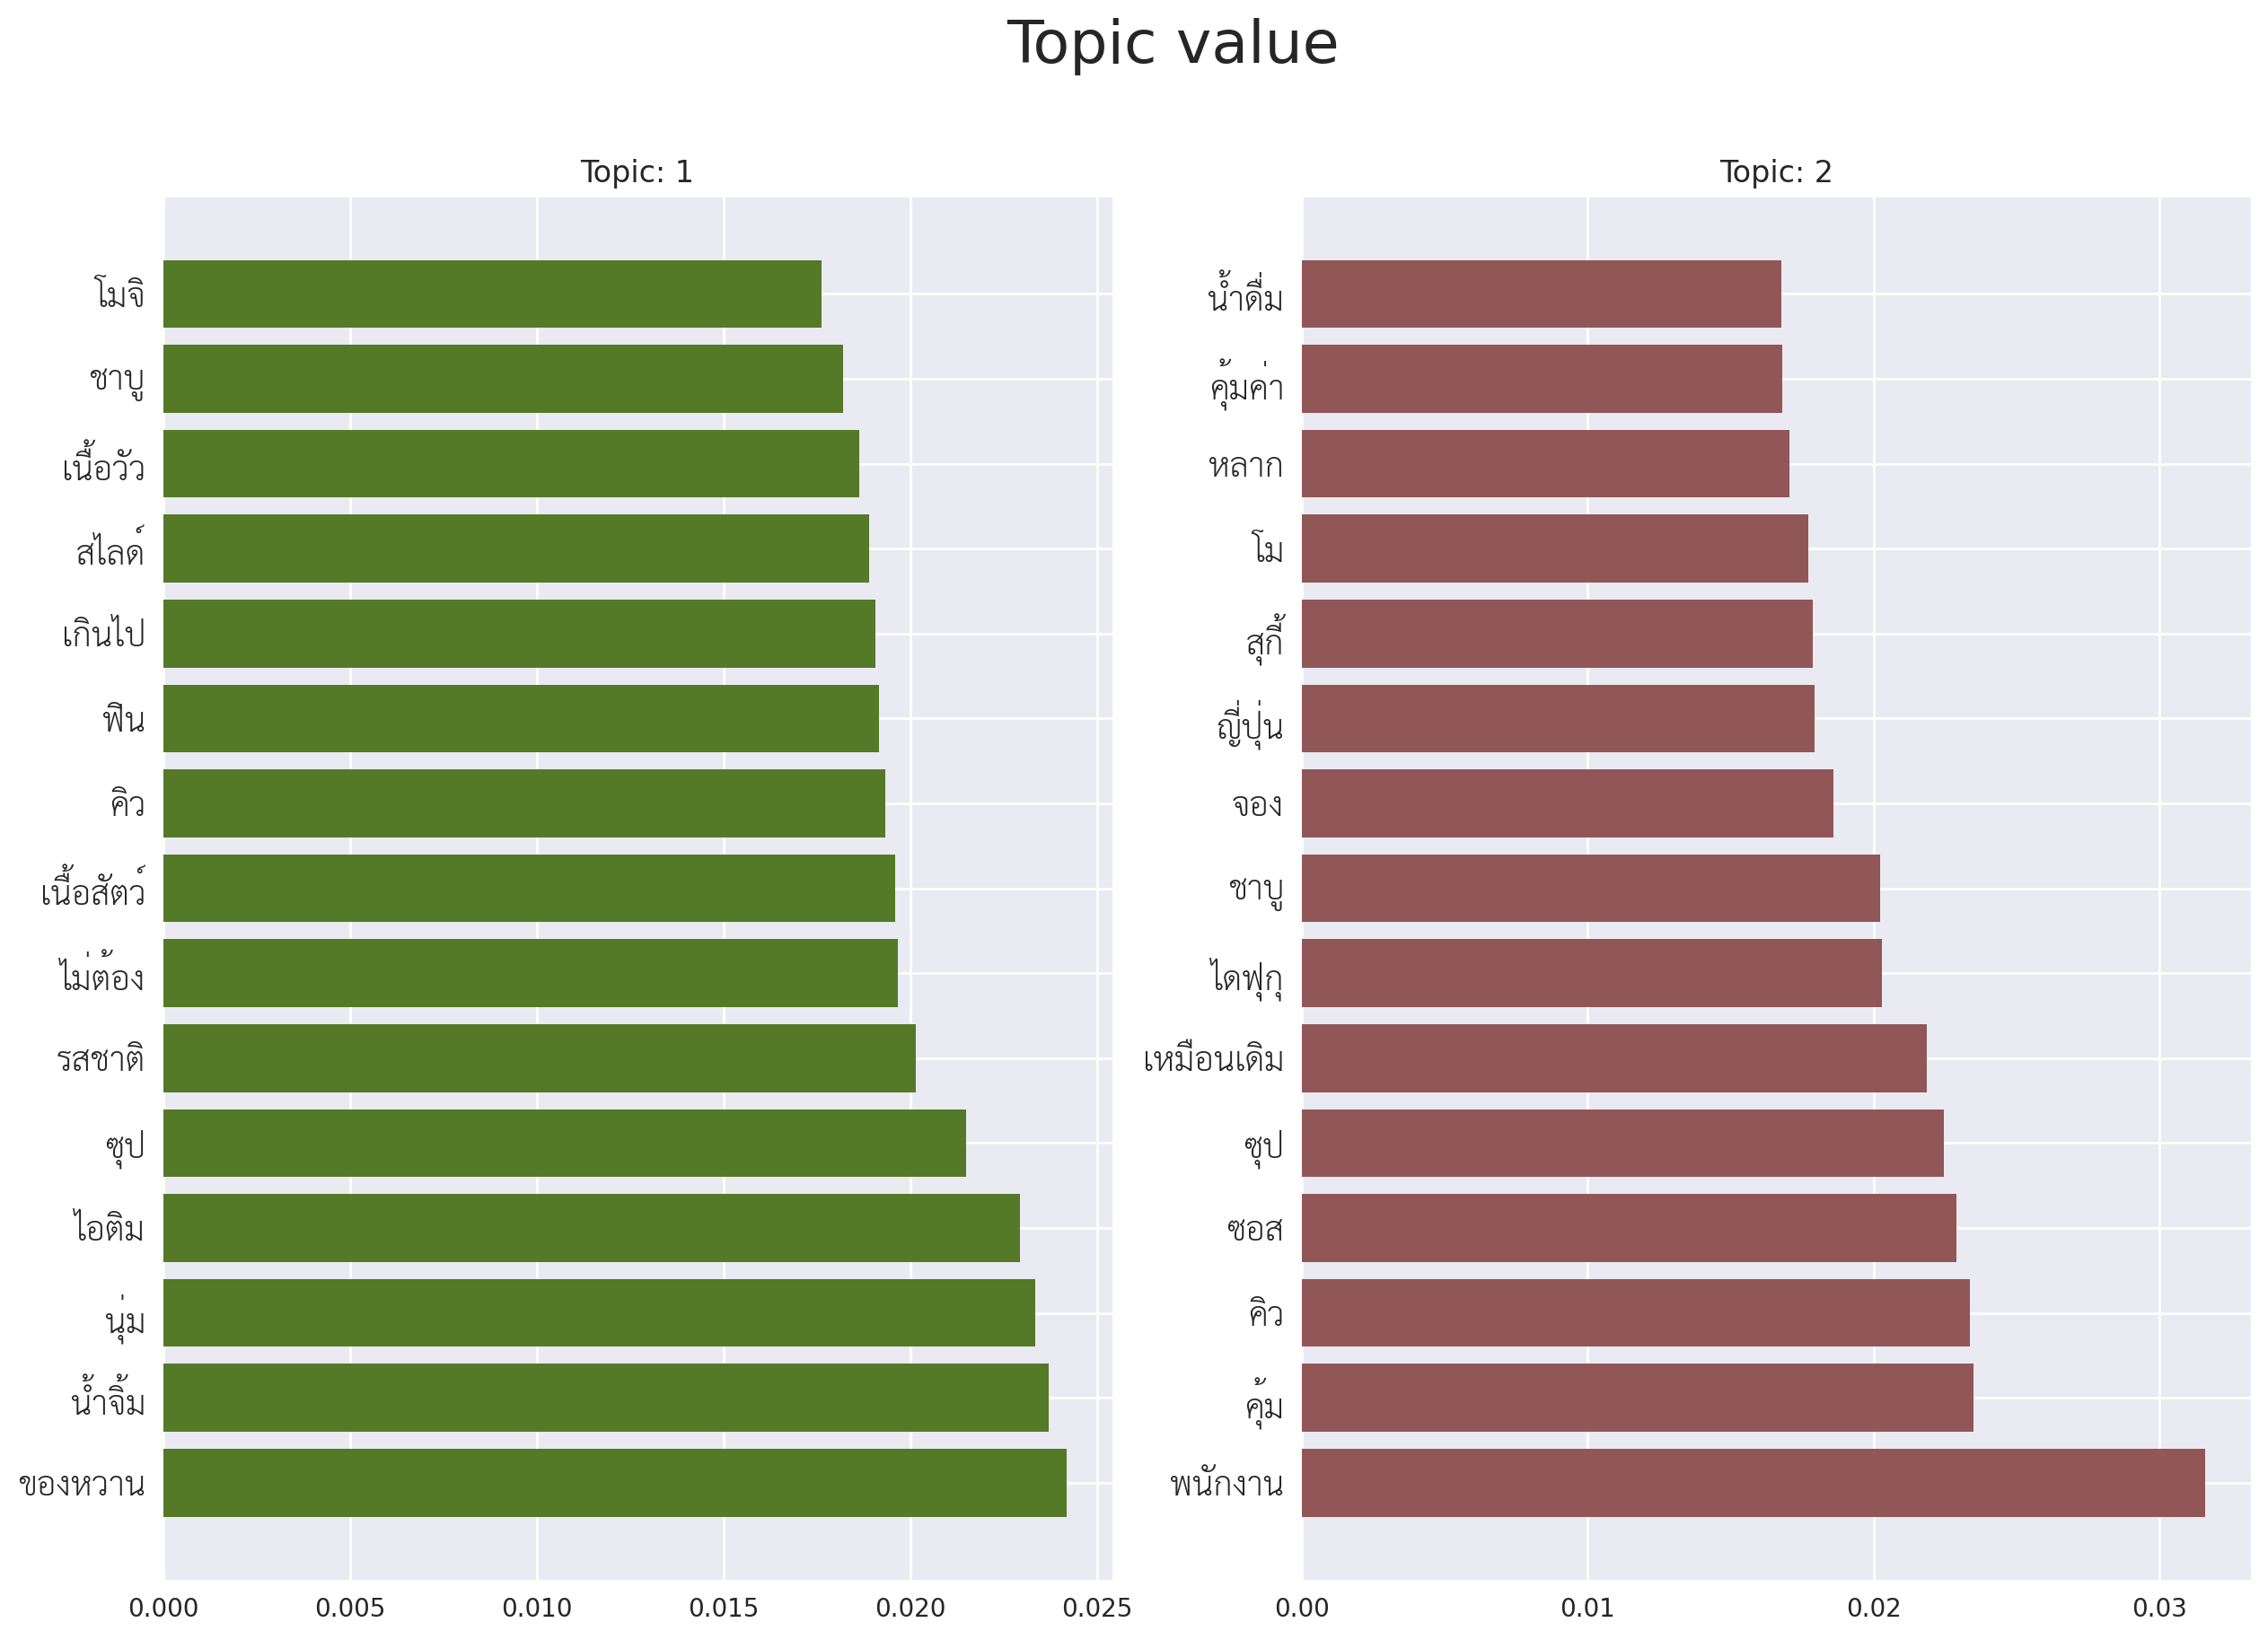

In [24]:
# Topic modeling with LDA
from gensim.models import LdaModel
from gensim.models import CoherenceModel

# Build model
LDAModel = LdaModel(corpus = TFIDFCorpus,
                    id2word = dictionary,
                    num_topics = nTopics,
                    passes = 10,
                    alpha = 'auto',
                    eta = 'auto')

# Print topics
LDAModel.print_topics()

# Create summary tabel in DataFrame format
nWords = 15 #Set number of word in a topic
topicWords = None

for i, topic in enumerate(LDAModel.get_topics()):
    wordIndex = topic.argsort() #.argsort is sorting values by ascending (0 -> 1) and return index
    wordIndex = wordIndex[::-1][:nWords] #Get n index by descending order values from array
    value = topic[wordIndex] #Get values by array index
    word = [dictionary[id] for id in wordIndex] #Get word from dictionay[i], i represents index of word
    
    result = pd.DataFrame({'Topic': i + 1, 'Word': word, 'Value': value})
    if topicWords is None:
        topicWords = result.copy()
    else:
        topicWords = pd.concat([topicWords, result], axis = 0, ignore_index = True)

# Show result with pivot table
topicWords.groupby(['Topic'])['Word'].apply(lambda x: x.reset_index(drop = True)).unstack()

# Plot values
# Define font family
axsTickFont = {'family': 'TH Sarabun New',
                'size': 20}

with plt.style.context('seaborn'):
    fig, axs = plt.subplots(int(nTopics / 2), 2, figsize = (15, 10))
    fig.suptitle('Topic value')
    axs = axs.ravel()

    for i in range(nTopics):
        data = topicWords.query('Topic == @i + 1')
        value = data['Value']
        word = data['Word']
        position = np.arange(data.shape[0])
        axs[i].set_title(f'Topic: {i + 1}')
        axs[i].barh(position, value, color = np.random.rand(3))
        axs[i].set_yticks(position) #To set ticks based on number of labels
        axs[i].set_yticklabels(list(word), **axsTickFont) #**kwargs for Thai font option

# plt.savefig('wordValues.png')
plt.show()

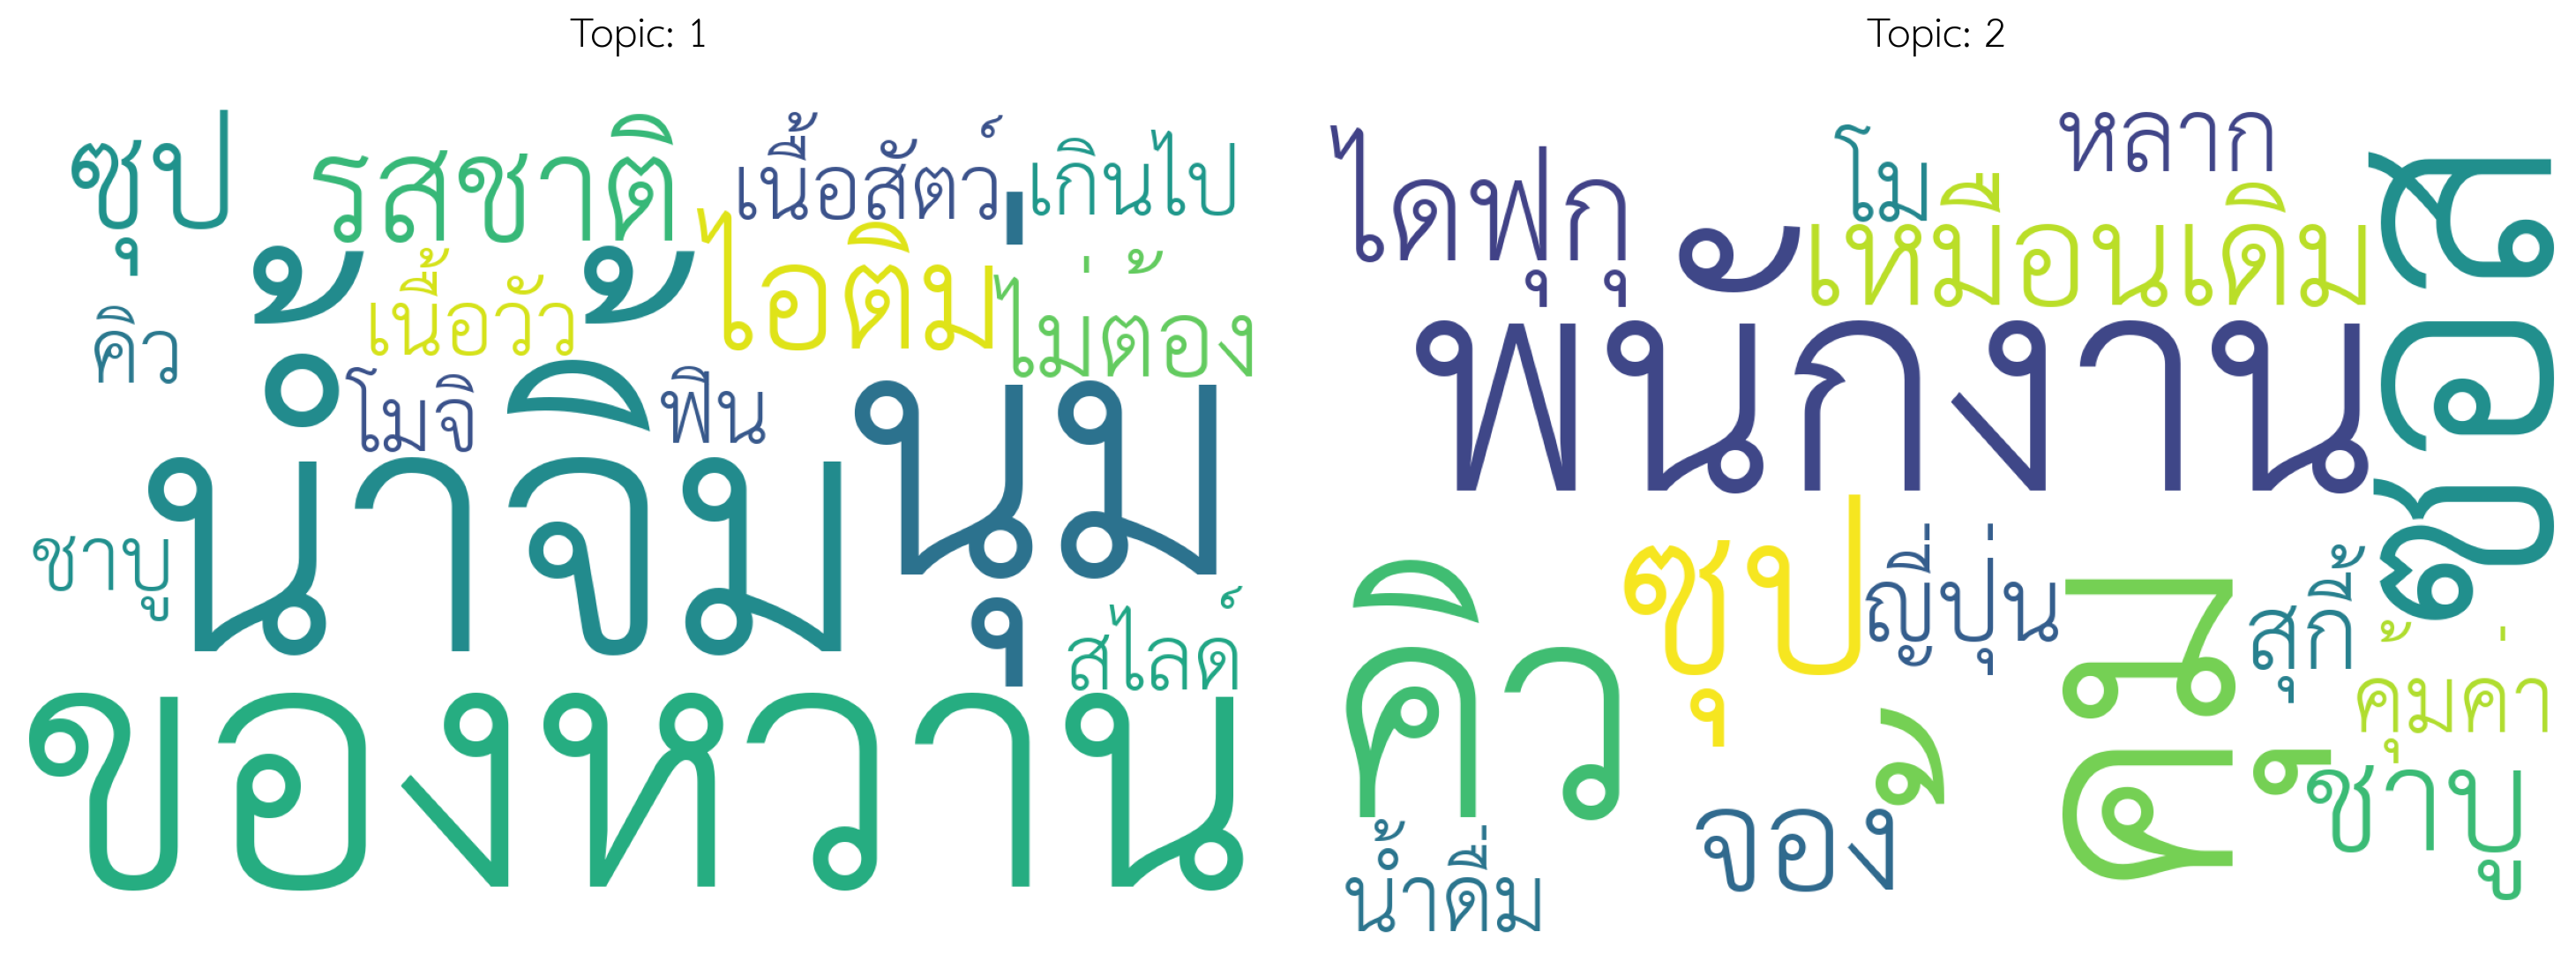

In [25]:
# Plot word cloud
fig = plt.figure(figsize = (15, 10))

for i in range(nTopics):
    data = topicWords.query('Topic == @i + 1')['Word'] #Extract only word
    ax = fig.add_subplot(int(nTopics / 2), 2, i + 1)
    ax.set_title(f'Topic: {i + 1}\n')
    wordcloud = plotWord(data)
    ax.imshow(wordcloud)
    ax.axis('off')
fig.tight_layout()
plt.show()